<a href="https://colab.research.google.com/github/carlosherediapimienta/Quantum_Neural_Network/blob/main/Quantum_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installation of libraries

In [8]:
!pip install qiskit
!pip install qiskit-machine-learning
!pip install pylatexenc

# Classification with Quantum Classifier

In [10]:
num_inputs = 2 # Defines the number of features in each sample
num_samples = 20 # Sets the number of training samples

In [11]:
from qiskit_algorithms.utils import algorithm_globals

# Generates a data set X with random values between -1 and 1 for two features.
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1

In [21]:
import numpy as np

# Creates binary labels (y01) based on whether the sum of the features in
# each sample is greater than or equal to zero. These labels are in {0, 1}.
y01 = 1 * (np.sum(X, axis=1) >= 0)

# We convert binary labels in {-1, 1}
y = 2 * y01 - 1

In [22]:
# Initializes an array of zeros for one-hot encoding of labels.
y_one_hot = np.zeros((num_samples, 2))

for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

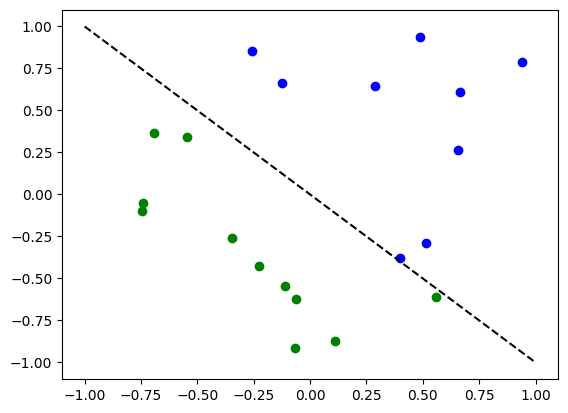

In [23]:
import matplotlib.pyplot as plt

# Visualizing:
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

## Classification with an EstimatorQNN

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


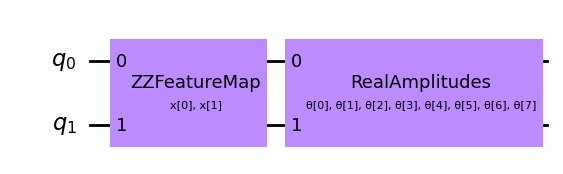

In [26]:
from qiskit_machine_learning.circuit.library import QNNCircuit

qc = QNNCircuit(num_qubits=2)
qc.draw(output="mpl")

In [30]:
from qiskit_machine_learning.neural_networks import EstimatorQNN

# We create a quantum Neural Network:
estimator_qnn = EstimatorQNN(circuit=qc)

# Generates a set of random weights using the random function
estimator_qnn.forward(
    X[0, :], algorithm_globals.random.random(estimator_qnn.num_weights)
    )

array([[0.75458493]])

In [33]:
from IPython.display import clear_output

objective_func_vals = []
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [34]:
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import COBYLA

# construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
)

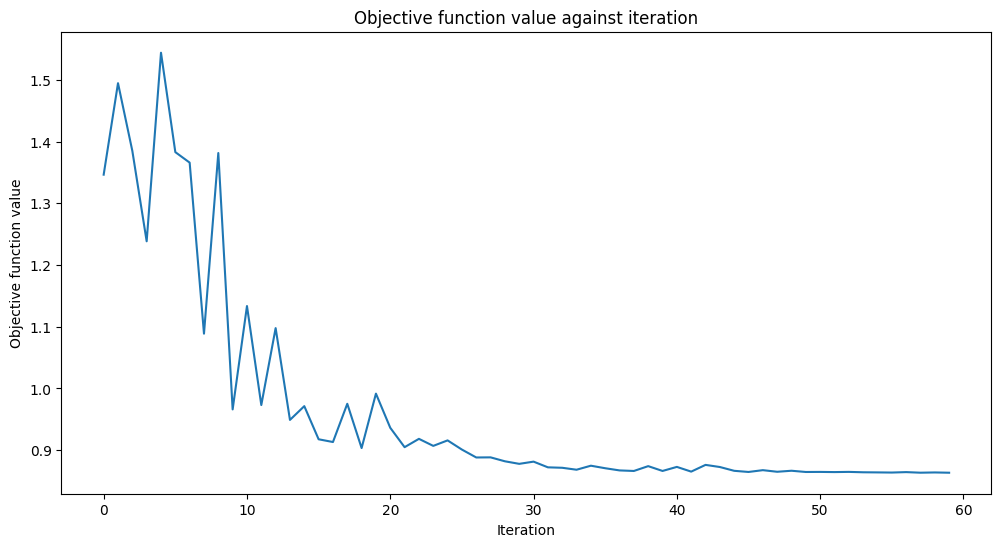

0.75

In [35]:
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(X, y)

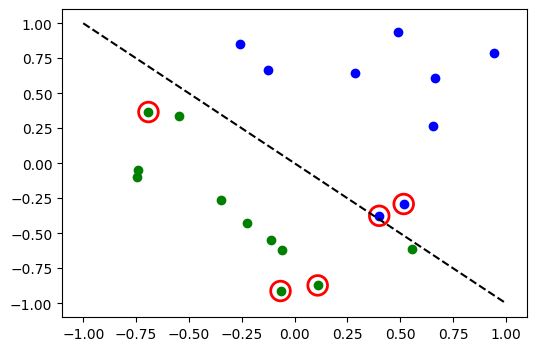

In [36]:
# evaluate data points
y_predict = estimator_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

## Classification with a SamplerQNN

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


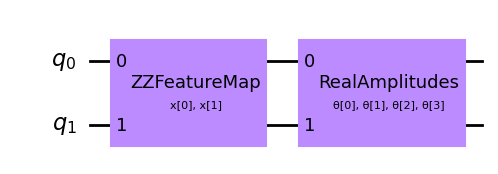

In [37]:
from qiskit.circuit.library import RealAmplitudes

# construct a quantum circuit from the default ZZFeatureMap
# feature map and a customized RealAmplitudes ansatz
qc = QNNCircuit(ansatz=RealAmplitudes(num_inputs, reps=1))
qc.draw(output="mpl")

In [38]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2

 # corresponds to the number of classes, possible outcomes of the mapping.
output_shape = 2

In [39]:
from qiskit_machine_learning.neural_networks import SamplerQNN

# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    interpret=parity,
    output_shape=output_shape,
)

In [41]:
# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=COBYLA(maxiter=30),
    callback=callback_graph
)

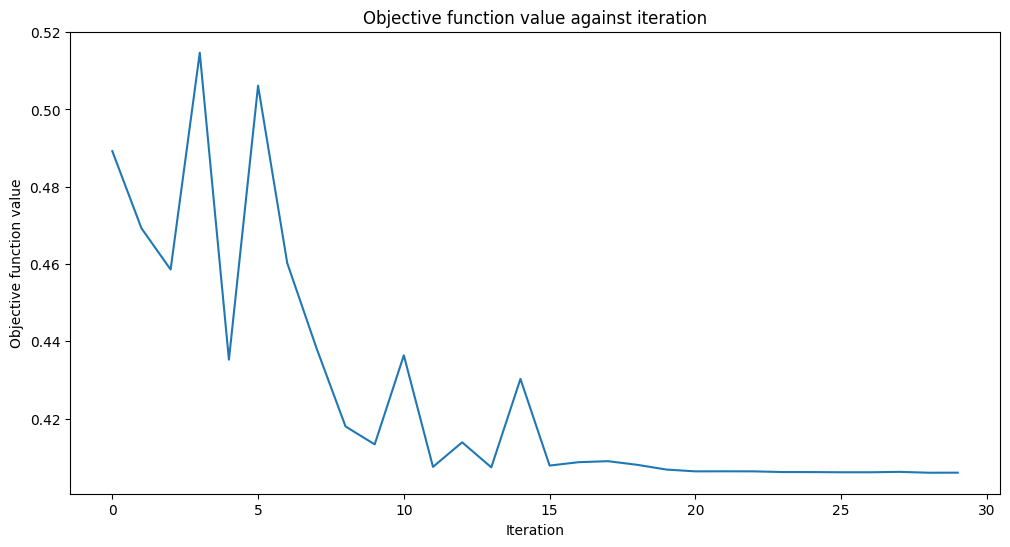

0.7

In [42]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
sampler_classifier.score(X, y01)

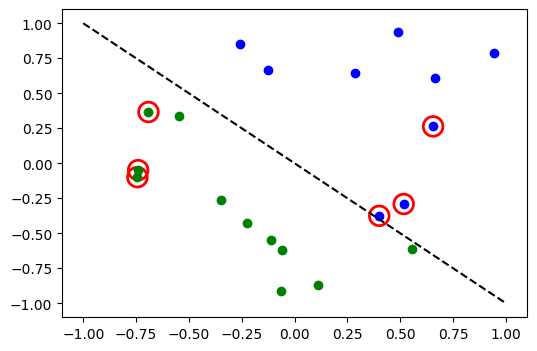

In [43]:
# evaluate data points
y_predict = sampler_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r",
                    linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

## Variational Quantum Classifier (VQC)

In [44]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import VQC

# construct feature map, ansatz, and optimizer
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph,
)

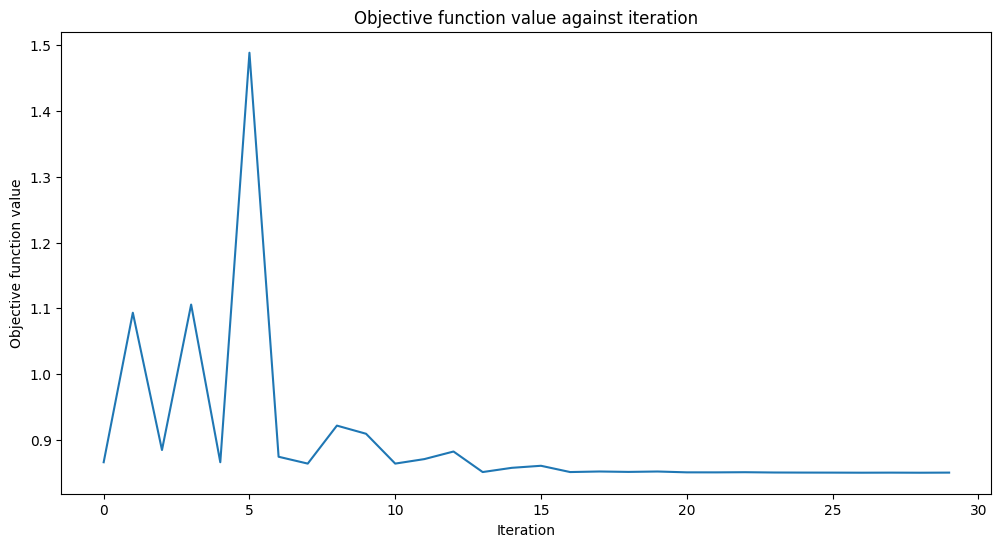

0.7

In [45]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_one_hot)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X, y_one_hot)